# Multi-Value Input: MovieLens

This example shows how to use DeepFM with sequence(multi-value) feature.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.sequence import pad_sequences

from deepctr.models import DeepFM 
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names

In [5]:
data = pd.read_csv("./movielens_sample.txt")
sparse_features = ["movie_id", "user_id",
                       "gender", "age", "occupation", "zip", ]
target = ['rating']

In [6]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [8]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     200 non-null    int64 
 1   movie_id    200 non-null    int64 
 2   rating      200 non-null    int64 
 3   timestamp   200 non-null    int64 
 4   title       200 non-null    object
 5   genres      200 non-null    object
 6   gender      200 non-null    int64 
 7   age         200 non-null    int64 
 8   occupation  200 non-null    int64 
 9   zip         200 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 15.8+ KB


,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,107,12,4,968035345,Ed Wood (1994),Comedy|Drama,0,2,4,35
1,123,169,3,966536874,Patriot Games (1992),Action|Thriller,1,1,4,118
2,12,6,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,0,2,13,99
3,21,112,3,975430389,Indiana Jones and the Temple of Doom (1984),Action|Adventure,1,1,18,55
4,187,45,5,957782527,"Apartment, The (1960)",Comedy|Drama,1,5,19,41


In [9]:
key2index = {}

def split(x):
    global key2index
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [13]:
# preprocess the sequence feature
genres_list = list(map(split, data["genres"].values))
key2index

{'Comedy': 1,
 'Drama': 2,
 'Action': 3,
 'Thriller': 4,
 'Romance': 5,
 'Adventure': 6,
 "Children's": 7,
 'Western': 8,
 'Horror': 9,
 'Fantasy': 10,
 'Sci-Fi': 11,
 'Animation': 12,
 'Crime': 13,
 'Film-Noir': 14,
 'Musical': 15,
 'War': 16,
 'Mystery': 17}

In [18]:
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
max_len, genres_list[:2]

(5, [[1, 2], [3, 4]])

In [20]:
genres_list = pad_sequences(genres_list, maxlen=max_len, padding="post")
type(genres_list), genres_list[:2]

(numpy.ndarray,
 array([[1, 2, 0, 0, 0],
        [3, 4, 0, 0, 0]], dtype=int32))

In [45]:
# 2.count #unique features for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=4) for feat in sparse_features]
use_weighted_sequence = True 
if use_weighted_sequence:
    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', 
                                                          vocabulary_size=len(key2index) + 1, 
                                                          embedding_dim=4), 
                                                maxlen=max_len, 
                                                combiner='mean',
                                                weight_name='genres_weight')]  
else:
    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', 
                                                          vocabulary_size=len(key2index) + 1, 
                                                          embedding_dim=4), 
                                                maxlen=max_len, 
                                                combiner='mean',
                                                weight_name=None)]  # Notice : value 0 is for padding for sequence input feature



In [46]:
varlen_feature_columns

[VarLenSparseFeat(sparsefeat=SparseFeat(name='genres', vocabulary_size=18, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x75e0c6fcd910>, embedding_name='genres', group_name='default_group', trainable=True), maxlen=5, combiner='mean', length_name=None, weight_name='genres_weight', weight_norm=True)]

In [47]:
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

In [48]:
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
if use_weighted_sequence:
    feature_names.remove("genres_weight")
feature_names

['movie_id', 'user_id', 'gender', 'age', 'occupation', 'zip', 'genres']

In [49]:
model_input = {name: data[name] for name in feature_names if name != "genre_weights"}
model_input["genres"] = genres_list
model_input["genres_weight"] = np.random.randn(data.shape[0], max_len, 1)

In [50]:
model_input["genres_weight"][0]

array([[ 0.99192751],
       [ 0.81561859],
       [-1.10052999],
       [ 0.95307719],
       [ 0.43333495]])

In [51]:
linear_feature_columns

[SparseFeat(name='movie_id', vocabulary_size=187, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x75e0ce86d790>, embedding_name='movie_id', group_name='default_group', trainable=True),
 SparseFeat(name='user_id', vocabulary_size=193, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x75e0ce86d450>, embedding_name='user_id', group_name='default_group', trainable=True),
 SparseFeat(name='gender', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x75e0ce86d250>, embedding_name='gender', group_name='default_group', trainable=True),
 SparseFeat(name='age', vocabulary_size=7, embedding_dim=4, use_hash=False, vocab

In [52]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'], )

In [53]:
EPOCHS = 20
BATCH_SIZE = 32
history = model.fit(model_input, data[target].values, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=0.2, )

Epoch 1/20
5/5 - 1s - loss: 14.0843 - mse: 14.0843 - val_loss: 12.9107 - val_mse: 12.9107
Epoch 2/20
5/5 - 0s - loss: 13.2909 - mse: 13.2909 - val_loss: 11.9695 - val_mse: 11.9695
Epoch 3/20
5/5 - 0s - loss: 12.0642 - mse: 12.0642 - val_loss: 10.4414 - val_mse: 10.4414
Epoch 4/20
5/5 - 0s - loss: 9.9928 - mse: 9.9928 - val_loss: 8.0612 - val_mse: 8.0612
Epoch 5/20
5/5 - 0s - loss: 7.0885 - mse: 7.0885 - val_loss: 4.8179 - val_mse: 4.8179
Epoch 6/20
5/5 - 0s - loss: 3.5268 - mse: 3.5268 - val_loss: 1.7798 - val_mse: 1.7798
Epoch 7/20
5/5 - 0s - loss: 1.2569 - mse: 1.2569 - val_loss: 1.5849 - val_mse: 1.5849
Epoch 8/20
5/5 - 0s - loss: 2.0151 - mse: 2.0151 - val_loss: 1.5983 - val_mse: 1.5983
Epoch 9/20
5/5 - 0s - loss: 1.3446 - mse: 1.3446 - val_loss: 1.2428 - val_mse: 1.2428
Epoch 10/20
5/5 - 0s - loss: 0.9326 - mse: 0.9326 - val_loss: 1.4624 - val_mse: 1.4624
Epoch 11/20
5/5 - 0s - loss: 0.9790 - mse: 0.9790 - val_loss: 1.4623 - val_mse: 1.4623
Epoch 12/20
5/5 - 0s - loss: 0.7494 - ms

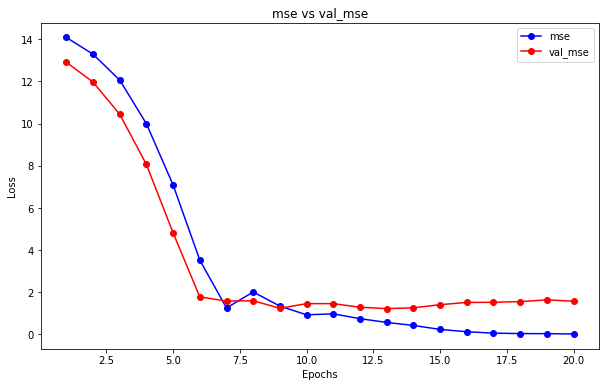

In [54]:
import matplotlib.pyplot as plt
# Extract loss and validation loss values
def plot_history(history, train_metric: str, val_metric: str):
    history_dict = history.history

    loss = history_dict[train_metric]
    val_loss = history_dict[val_metric]
    # Create an array with epoch numbers
    epochs = range(1, len(loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label=train_metric)
    plt.plot(epochs, val_loss, 'ro-', label=val_metric)
    plt.title(f'{train_metric} vs {val_metric}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history, "mse", "val_mse")

In [56]:
from sklearn.metrics import mean_squared_error

In [58]:
pred_ans = model.predict(model_input, batch_size=256)
print("test MSE", round(mean_squared_error(
    data[target].values, pred_ans), 4))

test MSE 0.3269


In [61]:
data[target].values[:10], pred_ans[:10]

(array([[4],
        [3],
        [4],
        [3],
        [5],
        [1],
        [5],
        [5],
        [5],
        [3]]),
 array([[4.0376425],
        [2.9441457],
        [4.027002 ],
        [2.938442 ],
        [5.086524 ],
        [1.5418841],
        [5.084824 ],
        [5.0851555],
        [5.0788636],
        [2.9272664]], dtype=float32))